In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn import preprocessing
from alphavantage_api.AlphaVantageCommodities import AlphaVantageCommodities
from tools.PandasDataFrameNormalizer import PandasDataFrameNormalizer
from dotenv import load_dotenv
import seaborn as sns

load_dotenv()

True

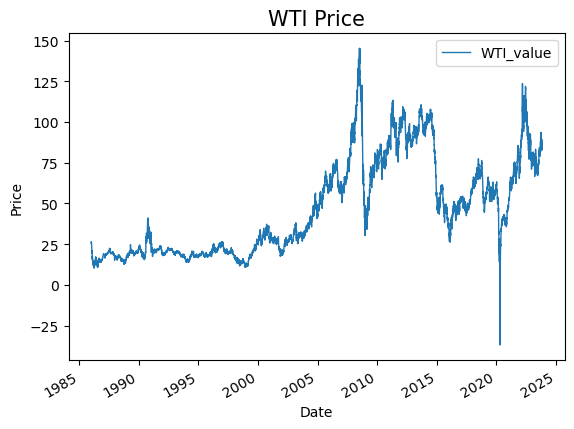

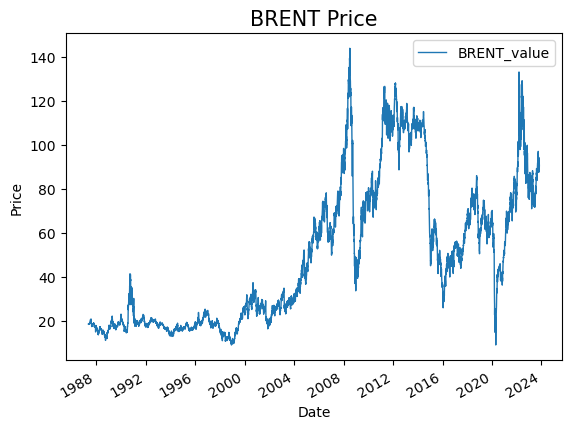

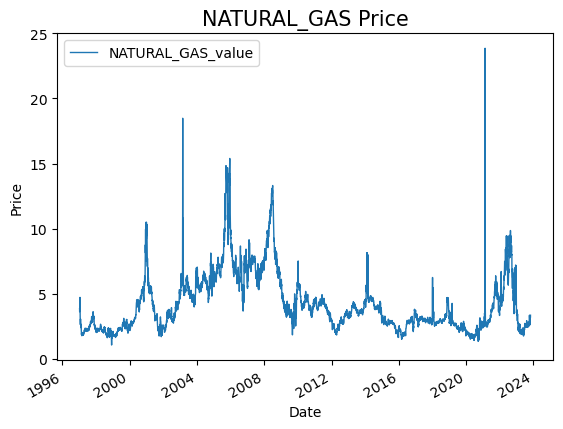

In [2]:
avc = AlphaVantageCommodities()
for symbol in avc.get_all_curated_series_ids():
    avc.plot_series_id(symbol)

In [3]:
df_merged = avc.get_data_as_pandas_df_multiple_series_ids(['WTI','BRENT','NATURAL_GAS'])

In [4]:
df_merged = df_merged.dropna()

<Axes: xlabel='date'>

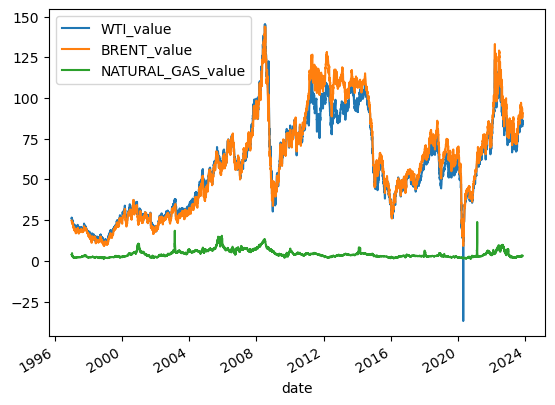

In [5]:
df_merged.plot(x="date")

<Axes: >

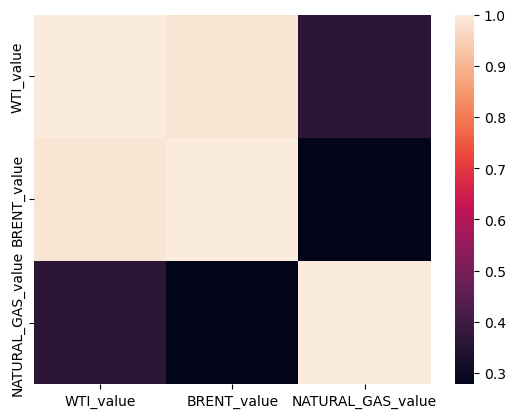

In [6]:
df_corr = df_merged.corr(numeric_only=True)
sns.heatmap(df_corr)

In [7]:
# Normalize data
normalizer_wti = PandasDataFrameNormalizer()
df_normalized = normalizer_wti.normalize_pandas_data_frame_column(df_merged,'WTI_value')

normalizer_brent = PandasDataFrameNormalizer()
df_normalized = normalizer_brent.normalize_pandas_data_frame_column(df_merged,'BRENT_value')

normalizer_natural_gas = PandasDataFrameNormalizer()
df_normalized = normalizer_natural_gas.normalize_pandas_data_frame_column(df_merged,'NATURAL_GAS_value')

In [8]:
df_normalized.tail()

,date,WTI_value,BRENT_value,NATURAL_GAS_value
9525,2023-10-24,0.666850,0.585095,0.078913
9526,2023-10-25,0.675023,0.600964,0.079351
9527,2023-10-26,0.662571,0.588432,0.079790
9528,2023-10-27,0.674859,0.605339,0.096011
9529,2023-10-30,0.658347,0.605339,0.092942


<Axes: xlabel='date'>

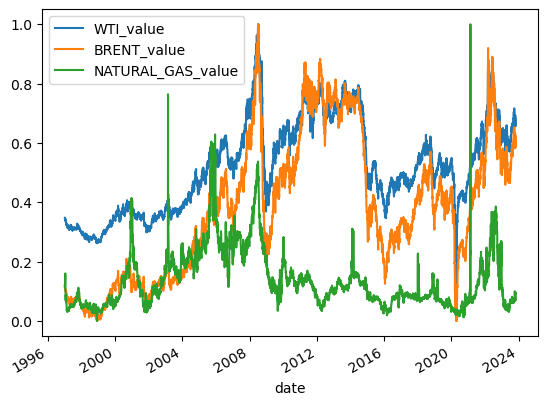

In [9]:
df_normalized.plot(x="date")

In [10]:
data = df_normalized[['WTI_value','BRENT_value','NATURAL_GAS_value']].to_numpy()
data

array([[0.3468649 , 0.11612904, 0.12143796],
       [0.34851062, 0.11627735, 0.12056115],
       [0.34713918, 0.11664813, 0.11223147],
       ...,
       [0.66257066, 0.5884316 , 0.07978956],
       [0.6748588 , 0.60533935, 0.09601052],
       [0.6583466 , 0.60533935, 0.09294169]], dtype=float32)

In [11]:
data.size

19956

In [12]:
np.shape(data)

(6652, 3)

In [13]:
print('Data lenght: ' + str(len(data)))

Data lenght: 6652


In [14]:
left_size = 0.8
split_at = int(left_size * len(data))
print('Split at: ' + str(split_at))

Split at: 5321


In [15]:
forecasting_label_steps = 10
feature_sequence_length = 100

x_train = data[0:split_at]
x_train_data = x_train[:-(feature_sequence_length+forecasting_label_steps)]
x_train_targets = x_train[feature_sequence_length+forecasting_label_steps:, 0]

x_test = data[split_at+1:]
x_test_data = x_test[:-(feature_sequence_length+forecasting_label_steps)]
x_test_targets = x_test[feature_sequence_length+forecasting_label_steps:, 0]

In [16]:
len(x_train_data)

5211

In [17]:
len(x_train_targets)

5211

In [18]:
len(x_test_data)

1220

In [19]:
x_train_data[100:,0]

array([0.3142246 , 0.3114817 , 0.3070931 , ..., 0.5171431 , 0.51648474,
       0.5182402 ], dtype=float32)

In [20]:
x_train_targets

array([0.3065445 , 0.30572167, 0.3048988 , ..., 0.5638817 , 0.55812174,
       0.5622361 ], dtype=float32)

In [21]:
dataset_train = tf.keras.utils.timeseries_dataset_from_array(x_train_data, x_train_targets, sequence_length=feature_sequence_length, sampling_rate=1, batch_size=256)

In [22]:
#for inputs, targets in dataset_train:
#  print("Input:", inputs.numpy(), "Target:", targets.numpy())

In [23]:
dataset_test = tf.keras.utils.timeseries_dataset_from_array(x_test_data, x_test_targets, sequence_length=feature_sequence_length, sampling_rate=1, batch_size=256)

In [24]:
for batch in dataset_train.take(1):
    inputs, targets = batch
    
print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (256, 100, 3)
Target shape: (256,)


In [25]:
layer_inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
layer_lstm_out = keras.layers.LSTM(32)(layer_inputs)
layer_outputs = keras.layers.Dense(1)(layer_lstm_out)

model = keras.Model(inputs=layer_inputs, outputs=layer_outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 3)]          0         
                                                                 
 lstm (LSTM)                 (None, 32)                4608      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 4641 (18.13 KB)
Trainable params: 4641 (18.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [26]:
path_checkpoint = "model_multi_checkpoint.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5)

In [27]:
modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

In [ ]:
history = model.fit(
    dataset_train,
    epochs=5,
    validation_data=dataset_test,
    callbacks=[es_callback, modelckpt_callback],
)

Epoch 1/5
20/20 [==============================] - ETA: 0s - loss: 0.0451
Epoch 1: val_loss improved from inf to 0.02467, saving model to model_multi_checkpoint.h5
20/20 [==============================] - 4s 112ms/step - loss: 0.0451 - val_loss: 0.0247
Epoch 2/5
20/20 [==============================] - ETA: 0s - loss: 0.0080

In [ ]:
pd.DataFrame(history.history).plot()

In [ ]:
def plot(input_data, predicted_data, output_compare):
    compare_y = list(range(feature_sequence_length+forecasting_label_steps, feature_sequence_length+forecasting_label_steps+ len(output_compare)))
    predicted_y = list(range(feature_sequence_length, feature_sequence_length + len(output_compare)))

    plt.figure(figsize=(20,6))
    plt.plot(input_data, label = "past", linestyle = 'dashed')
    plt.plot(compare_y, predicted_data, label = "predicted")
    plt.plot(compare_y, output_compare, label = "real data", linestyle = 'dotted')
    plt.plot(feature_sequence_length, input_data[feature_sequence_length], "rx", label = "start prediction")
    plt.legend()
    plt.show()

In [ ]:
for x, y in dataset_test.take(1):
    #print(x)
    #print(y)
    predicted_data = normalizer_wti.inverse_transform_numpy_array(model.predict(x.numpy()))
    #input_data = list(x.as_numpy_iterator())[0][0][:, 1]
    #print(x[:,0,0])
    input_data = normalizer_wti.inverse_transform_numpy_array(x[:, 0, 0].numpy())
    #print("input")
    #print(input_data)
    #output_compare = list(x.as_numpy_iterator())[0][1]
    output_compare = normalizer_wti.inverse_transform_numpy_array(y.numpy())
    #print("output")
    #print(output_compare)
    plot(input_data, predicted_data, output_compare)